In [1]:
from scipy.stats import entropy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import digamma, gamma, psi, gammaln
from scipy.stats import dirichlet, pearsonr

In [2]:
import pandas as pd
df = pd.read_csv("ensemble_predictions-FromScratch.csv")
keep_cols = df.columns

preds = df.drop(['Path'], axis=1).values

# df.iloc[val_idxs].to_csv("new_val.csv", index=False)
# df.iloc[train_idxs].to_csv("new_train.csv", index=False)

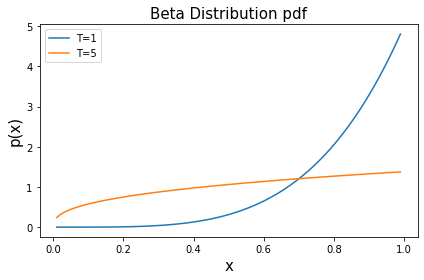

In [3]:
from scipy.stats import beta

x=np.linspace(0.01,0.99,100)
a = 5 
b = 1
T = 5
y = beta.pdf(x, a, b)
a_t = np.exp(np.log(a)/T)
b_t = np.exp(np.log(b)/T)
y_t = beta.pdf(x,a_t,b_t)
plt.figure()
plt.plot(x,y,label='T=1')
plt.plot(x,y_t,label='T=5')
plt.legend()
plt.xlabel('x',fontsize=15)
plt.ylabel('p(x)',fontsize=15)
plt.title('Beta Distribution pdf',fontsize=15)
plt.tight_layout()

plt.savefig('temperature.png')

In [4]:
## data uncertainty
alphas=np.ones(2)
alpha_0=np.ones(2)+1
expected_entropy = -np.sum(
        np.exp(np.log(alphas) - np.log(alpha_0)) * (digamma(alphas + 1.0) - digamma(alpha_0 + 1.0)))
expected_entropy

0.5

## Total Uncertainty

In [5]:
tasks = preds.shape[1]
Tu = np.zeros((preds.shape[0],preds.shape[1]))

for task in range(tasks):
    y = preds[:,task]
    Tu[:,task] = entropy([y,1-y],base=2)
#     Tu[:,task] = entropy([y,1-y])
    

print(np.mean(Tu,axis=0))
print(np.mean(Tu))

[0.75151593 0.7389685  0.91272574 0.90161045 0.67647428]
0.7962589804645315


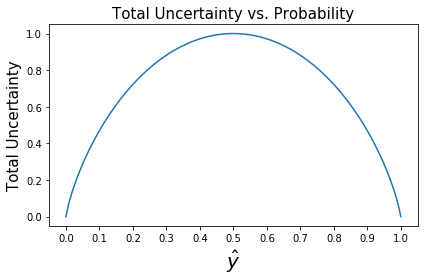

In [6]:
ys = np.linspace(0,1,100)
ent = np.array([entropy([y,1-y],base=2)for y in ys])
xt = np.linspace(0,1,11)
# plt.gcf().subplots_adjust(bottom=0.15)
plt.figure()
plt.plot(ys,ent)
plt.xlabel('$\^y$',fontsize=20)
plt.ylabel('Total Uncertainty',fontsize=15)
plt.xticks(xt)
plt.title('Total Uncertainty vs. Probability', fontsize=15)
plt.tight_layout()

plt.savefig('TU.png')

## Data Uncertainty

In [7]:
df = pd.read_csv("ensemble_results-FromScratch.csv",header=None)

# raw = df.drop(['Path'], axis=1).values
# raw
results = df.drop([0], axis=1).values
results.shape

Du = np.zeros((preds.shape[0],preds.shape[1]))

for model in range(6):
    for task in range(tasks):
        col = (model*5) +task
        y = results[:,col]
        Du[:,task] += entropy([y,1-y],base=2)
        
        
Du /= 6
print(np.mean(Du,axis=0))
print(np.mean(Du))

[0.72383696 0.71710204 0.9020234  0.89220902 0.64388073]
0.7758104272500758


## Knowledge Uncertainty

In [8]:
Ku = Tu - Du
print(np.mean(Ku,axis=0))
print(np.mean(Ku))

[0.02767897 0.02186646 0.01070234 0.00940144 0.03259356]
0.02044855321445581


## Negative Log Likelihood

In [9]:
df = pd.read_csv("valid.csv")
keep_cols = ['Cardiomegaly','Edema','Consolidation','Atelectasis','Pleural Effusion']
g_truth = df[keep_cols].values
NLL = np.zeros(5)

for i in range(5):
    y = g_truth[:,i]
    p = preds[:,i]
    p = results[:,i]

    NLL[i] = np.sum(- y * np.log(p) - (1 - y) * np.log(1 - p))/len(y)
    
print(NLL)
print(np.mean(NLL))

[0.48772238 0.43861831 0.55340889 0.54368735 0.37238806]
0.47916499846490934


In [10]:
g_truth.shape

(234, 5)

## Expected Calibration Error

In [11]:
df = pd.read_csv("ensemble_predictions-FromScratch.csv")
df = df.drop(['Path'],axis=1)
df.columns

Index(['Cardiomegaly', 'Edema', 'Consolidation', 'Atelectasis',
       'Pleural Effusion'],
      dtype='object')

In [12]:
# import uncertainty_metrics.numpy as um



ece_ar = np.zeros(5)
num_bins=5
segs = np.linspace(0,1,num_bins+1)

for i in range(5):
    ece = 0
    for B in range(num_bins):
        lb = segs[B]
        ub = segs[B+1]
        idxs = np.where((preds[:,i] > lb) & (preds[:,i] <= ub))[0]
        confs = np.maximum(preds[:,i][idxs],1-preds[:,i][idxs])
        confs = np.fabs((preds[:,i][idxs] - 0.5) * 2)
        conf = np.mean(confs)
        
        y = preds[:,i][idxs]
        g = g_truth[:,i][idxs]
        y[y<0.5] = 0
        y[y>0.5] = 1
        acc = np.sum(y==g)/idxs.shape[0]
        fabs = np.fabs(acc-conf)
        if idxs.shape[0]:
            ece += idxs.shape[0]*fabs/preds[:,i].shape[0]
        
    ece_ar[i] = ece
    
   

    
print(ece_ar)
print(np.mean(ece_ar))

[0.28395843 0.3378377  0.526636   0.43598466 0.27933642]
0.37275064337250385


C:\Users\mish2\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\mish2\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\mish2\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


In [13]:
preds

array([[0.58917029, 0.29334755, 0.3415968 , 0.39973444, 0.10384724],
       [0.13219843, 0.03072102, 0.24663248, 0.17059039, 0.10014204],
       [0.12798398, 0.0450804 , 0.17192529, 0.13790739, 0.04027392],
       ...,
       [0.8042628 , 0.63432287, 0.2283395 , 0.27184999, 0.07772198],
       [0.61089861, 0.33638651, 0.20898626, 0.25800935, 0.07905421],
       [0.37532863, 0.3541747 , 0.52806415, 0.55633899, 0.65018637]])

In [14]:
a = np.linspace(0,1,10)
b = np.linspace(1,0,10)
c = np.maximum(a,b)
c

array([1.        , 0.88888889, 0.77777778, 0.66666667, 0.55555556,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

## Patch Accuracy Vs Patch Uncertainty

In [15]:
thres_s = np.linspace(0.5,1,100)
preds_c = preds.copy()
best=0
for thres in thres_s:
    p_ac = np.zeros(5)
    p_ui = np.zeros(5)
    pa_pu = np.zeros(5)
    for i in range(5):
        c_idxs = np.where((preds_c[:,i] > thres) | (preds_c[:,i] <= 1-thres))[0]
        uc_idxs = np.where((preds_c[:,i] < thres) & (preds_c[:,i] >= 1-thres))[0]
        gc = g_truth[:,i][c_idxs]
        yc = preds[:,i][c_idxs]
        yc[yc<0.5] = 0
        yc[yc>0.5] = 1
        gu = g_truth[:,i][uc_idxs]
        yu = preds[:,i][uc_idxs]
        yu[yu<0.5] = 0
        yu[yu>0.5] = 1
        nac = np.sum(yc==gc)
        nau = np.sum(yu==gu)
        nic = np.sum(yc!=gc)
        niu = np.sum(yu!=gu)
#         print(nac)
#         print(nau)
#         print(nic)
#         print(niu)
#         print('')
        p_ac[i] = nac/(nac+nic)
        p_ui[i] = niu/(niu+nic)
        pa_pu[i] = (nac + niu)/(nac + nau + nic + niu)


#     print(np.mean(p_ac))
#     print(np.mean(p_ui))
    pvp = np.mean(pa_pu)
    if pvp>best:
        best = pvp
        print('PAvsPU : ',pvp)
        print('p(a|c) : ',np.mean(p_ac))
        print('p(u|i) : ',np.mean(p_ui))
        print('')

PAvsPU :  0.8085470085470086
p(a|c) :  0.8085470085470086
p(u|i) :  0.0

PAvsPU :  0.8128205128205128
p(a|c) :  0.8151066198070257
p(u|i) :  0.04708879626079445

PAvsPU :  0.8145299145299145
p(a|c) :  0.819625138477892
p(u|i) :  0.08084233580089567



C:\Users\mish2\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars


In [16]:
preds.shape

(234, 5)

## OOD Detection-Gaussain Noise

In [17]:
df = pd.read_csv("ens_scratch_GaussNoise.csv",header=None)


ood_results = df.drop([0], axis=1).values

ood_preds =  np.zeros((preds.shape[0],preds.shape[1]))

for model in range(6):
    for task in range(5):
        col = (model*5) +task
        ood_preds[:,task] += ood_results[:,col]
        
        
ood_preds /= 6


In [18]:
tasks = preds.shape[1]
noise_tu = np.zeros((preds.shape[0],preds.shape[1]))
noise_ku = np.zeros((preds.shape[0],preds.shape[1]))
noise_du = np.zeros((preds.shape[0],preds.shape[1]))


for task in range(tasks):
    y = ood_results[:,task]
    noise_tu[:,task] = entropy([y,1-y],base=2)
#     Tu[:,task] = entropy([y,1-y])
    

print(np.mean(noise_tu,axis=0))
print(np.mean(noise_tu))

[2.32026953e-02 2.42150923e-04 8.54415871e-04 4.41911602e-01
 9.92967093e-01]
0.29183559155349975


In [19]:


for model in range(6):
    for task in range(tasks):
        col = (model*5) +task
        y = ood_results[:,col]
        noise_du[:,task] += entropy([y,1-y],base=2)
        
        
noise_du /= 6
print(np.mean(noise_du,axis=0))
print(np.mean(noise_du))

[0.19532038 0.26597338 0.21492274 0.53531139 0.32535623]
0.307376823388738


In [20]:
noise_ku = noise_tu-noise_du
print(np.mean(noise_ku,axis=0))
print(np.mean(noise_ku))

[-0.17211768 -0.26573123 -0.21406832 -0.09339979  0.66761086]
-0.01554123183523823


## OOD Detection MNIST

In [21]:
df = pd.read_csv("ens_scratch_MNIST_results.csv",header=None)


ood_results = df.drop([0], axis=1).values

ood_preds =  np.zeros((preds.shape[0],preds.shape[1]))

for model in range(6):
    for task in range(5):
        col = (model*5) +task
        ood_preds[:,task] += ood_results[:,col]
        
        
ood_preds /= 6
np.mean(ood_preds,axis=0)

array([0.59210345, 0.56427711, 0.39487728, 0.24508107, 0.21479944])

In [22]:
tasks = preds.shape[1]
noise_tu = np.zeros((preds.shape[0],preds.shape[1]))
noise_ku = np.zeros((preds.shape[0],preds.shape[1]))
noise_du = np.zeros((preds.shape[0],preds.shape[1]))


for task in range(tasks):
    y = ood_results[:,task]
    noise_tu[:,task] = entropy([y,1-y],base=2)
#     Tu[:,task] = entropy([y,1-y])
    

print(np.mean(noise_tu,axis=0))
print(np.mean(noise_tu))

[0.94467284 0.93271968 0.97866278 0.77284241 0.5888196 ]
0.8435434623610504


In [23]:


for model in range(6):
    for task in range(tasks):
        col = (model*5) +task
        y = ood_results[:,col]
        noise_du[:,task] += entropy([y,1-y],base=2)
        
        
noise_du /= 6
print(np.mean(noise_du,axis=0))
print(np.mean(noise_du))

[0.89610398 0.89527942 0.93862628 0.77390509 0.65878106]
0.8325391681387228


In [24]:
noise_ku = noise_tu-noise_du
print(np.mean(noise_ku,axis=0))
print(np.mean(noise_ku))

[ 0.04856885  0.03744026  0.0400365  -0.00106268 -0.06996146]
0.01100429422232772
